In [3]:
import pandas as pd

# Recharger les fichiers fusionnés
train_transaction_full = pd.read_csv("E:/Projet_ML_class/train_transaction.csv")
train_identity_full = pd.read_csv("E:/Projet_ML_class/train_identity.csv")

# Fusionner les deux datasets
train_df = pd.merge(train_transaction_full, train_identity_full, on='TransactionID', how='left')

# Résumer rapidement
shape_train = train_df.shape

# Pourcentage de valeurs manquantes
missing_values = (train_df.isnull().sum() / len(train_df)) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Distribution de 'isFraud'
fraud_distribution = train_df['isFraud'].value_counts(normalize=True) * 100

# Résumé de 'TransactionAmt'
transaction_amt_summary = train_df['TransactionAmt'].describe()

# Distribution 'DeviceType'
device_type_distribution = train_df['DeviceType'].value_counts(dropna=False)

shape_train, missing_values.head(10), fraud_distribution, transaction_amt_summary, device_type_distribution

((590540, 434),
 id_24    99.196159
 id_25    99.130965
 id_07    99.127070
 id_08    99.127070
 id_21    99.126393
 id_26    99.125715
 id_27    99.124699
 id_23    99.124699
 id_22    99.124699
 dist2    93.628374
 dtype: float64,
 0    96.500999
 1     3.499001
 Name: isFraud, dtype: float64,
 count    590540.000000
 mean        135.027176
 std         239.162522
 min           0.251000
 25%          43.321000
 50%          68.769000
 75%         125.000000
 max       31937.391000
 Name: TransactionAmt, dtype: float64,
 NaN        449730
 desktop     85165
 mobile      55645
 Name: DeviceType, dtype: int64)

# 1. Variables V* – Traitement
# a. Supprimer les quasi-constantes (≥ 80% même valeur)


In [4]:
V_cols = [col for col in train_df.columns if col.startswith('V')]

# Supprimer les variables où une seule valeur occupe plus de 80% des cas
quasi_constantes = [col for col in V_cols if train_df[col].value_counts(normalize=True, dropna=False).values[0] >= 0.8]

train_df.drop(columns=quasi_constantes, inplace=True)



# 2. Variables id_* – Traitement intelligent des NA
# a. Supprimer celles avec > 90% de valeurs manquantes

In [5]:
id_cols = [col for col in train_df.columns if col.startswith('id_')]

# Garder celles avec moins de 90% de NA
id_valid = [col for col in id_cols if train_df[col].isna().mean() < 0.9]


# 3.Vérifier différence de taux de fraude entre NA et non-NA (facultatif)
# c. Imputation

In [6]:
for col in id_valid:
    if train_df[col].dtype == 'object':  # qualitative
        train_df[col] = train_df[col].fillna('undefined')
    else:  # quantitative
        train_df[col] = train_df[col].fillna(-999)


# 3. Réduction des id_* par PPS (Predictive Power Score)

In [7]:
import ppscore as pps

# Calcul PPS entre chaque id_* et la cible
pps_scores = {}
for col in id_valid:
    try:
        score = pps.score(train_df[[col, 'isFraud']], col, 'isFraud')['ppscore']
        pps_scores[col] = score
    except:
        continue  # si la colonne pose problème

# Garder uniquement les colonnes les plus prédictives (ex : ppscore > 0.01)
id_selected = [col for col, score in pps_scores.items() if score > 0.01]

# Réduction finale
train_df = train_df[id_selected + [col for col in train_df.columns if not col.startswith('id_')]]


# 4. Créer une variable : nb d’id_* manquants

In [8]:
id_cols_all = [col for col in train_df.columns if col.startswith('id_')]
train_df['nb_id_na'] = train_df[id_cols_all].isna().sum(axis=1)


###  Listes des modéles pour la detection des fraudes

#### 1. Modéles linéaires

#### 2.Arbres de Décision & Ensembles

#### 3. Méthodes Probabilistes

#### 4. Modèles à base de distance

#### 5. Modèles à marge

#### 6. Réseaux de Neurones

## Comparaison des Modéles

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# ========================
# 1. Préparation des données
# ========================

df = train_df.copy()

# Encodage des variables catégorielles (simple)
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# Diviser les données avant l'imputation pour éviter la fuite de données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# ========================
# 2. Définir les modèles
# ========================

models = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000),
    "RandomForest": RandomForestClassifier(class_weight="balanced", n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
}

# ========================
# 3. Évaluer chaque modèle
# ========================

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    recall = report["1"]["recall"]
    f1 = report["1"]["f1-score"]

    results.append({
        "Modèle": name,
        "ROC AUC": round(auc, 4),
        "Recall": round(recall, 4),
        "F1-score": round(f1, 4)
    })

# ========================
# 4. Résultats
# ========================

results_df = pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False)
print(results_df)


[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.956174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24101
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 263
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
               Modèle  ROC AUC  Recall  F1-score
2             XGBoost   0.9412  0.4844    0.6280
4            CatBoost   0.9408  0.5161    0.6666
1        RandomForest   0.9396  0.4396    0.6020
3            LightGBM   0.9294  0.4300    0.5821
0  LogisticRegression   0.7490  0.7455    0.1183


NaN dans X_train : 0


#### les courbes ROC pour les top modèles

[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.530377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24101
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 263
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101


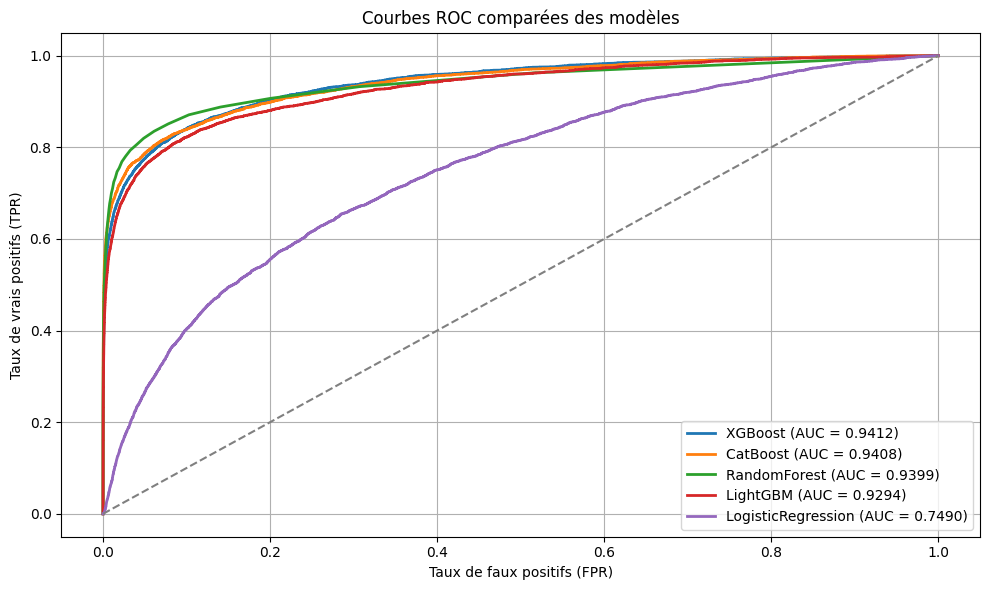

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC  # Import du modèle SVM

# Dictionnaire des modèles déjà entraînés (ajout de SVM)
models_trained = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0),
    "RandomForest": RandomForestClassifier(class_weight="balanced", n_estimators=100),
    "LightGBM": LGBMClassifier(),
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000),
   
}

# Réentraîner les modèles (si ce n'est pas déjà fait)
for name, model in models_trained.items():
    model.fit(X_train, y_train)

# Affichage des courbes ROC
plt.figure(figsize=(10, 6))

for name, model in models_trained.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.4f})")

# Ligne diagonale (random guess)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("Courbes ROC comparées des modèles")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Training des hyperparamétres

In [11]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

# Modèle avec hyperparamètres fixes (bons par défaut)
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist',  # Change en 'gpu_hist' si tu as un GPU
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    scale_pos_weight=5,  # À ajuster selon ton déséquilibre
    n_jobs=-1,
    random_state=42
)

# Entraînement direct
xgb_clf.fit(X_train, y_train)

# Prédictions
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Évaluation
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))
print("AUC :", roc_auc_score(y_test, y_proba))



Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.64      0.56      0.60      4133

    accuracy                           0.97    118108
   macro avg       0.81      0.78      0.79    118108
weighted avg       0.97      0.97      0.97    118108

AUC : 0.9254899689513201


#### vérifier le surapprentissage (overfitting) ou sous-apprentissage (underfitting)

In [19]:

pip uninstall xgboost -y


Found existing installation: xgboost 3.0.2
Uninstalling xgboost-3.0.2:
  Successfully uninstalled xgboost-3.0.2
Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.


In [20]:
pip install xgboost==1.7.6


   ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
    --------------------------------------- 1.0/70.9 MB 5.6 MB/s eta 0:00:13
   - -------------------------------------- 1.8/70.9 MB 5.9 MB/s eta 0:00:12
   - -------------------------------------- 3.1/70.9 MB 5.0 MB/s eta 0:00:14
   -- ------------------------------------- 3.7/70.9 MB 5.0 MB/s eta 0:00:14
   -- ------------------------------------- 4.2/70.9 MB 4.2 MB/s eta 0:00:16
   -- ------------------------------------- 4.7/70.9 MB 3.8 MB/s eta 0:00:18
   -- ------------------------------------- 5.2/70.9 MB 3.5 MB/s eta 0:00:19
   -- ------------------------------------- 5.2/70.9 MB 3.5 MB/s eta 0:00:19
   --- ------------------------------------ 5.5/70.9 MB 3.1 MB/s eta 0:00:21
   --- ------------------------------------ 5.8/70.9 MB 2.9 MB/s eta 0:00:23
   --- ------------------------------------ 6.3/70.9 MB 2.7 MB/s eta 0:00:24
   --- ------

ERROR: Could not install packages due to an OSError: [WinError 32] Le processus ne peut pas accéder au fichier car ce fichier est utilisé par un autre processus: 'C:\\Users\\DELL\\AppData\\Local\\Temp\\pip-unpack-px57yu82\\xgboost-1.7.6-py3-none-win_amd64.whl'
Consider using the `--user` option or check the permissions.



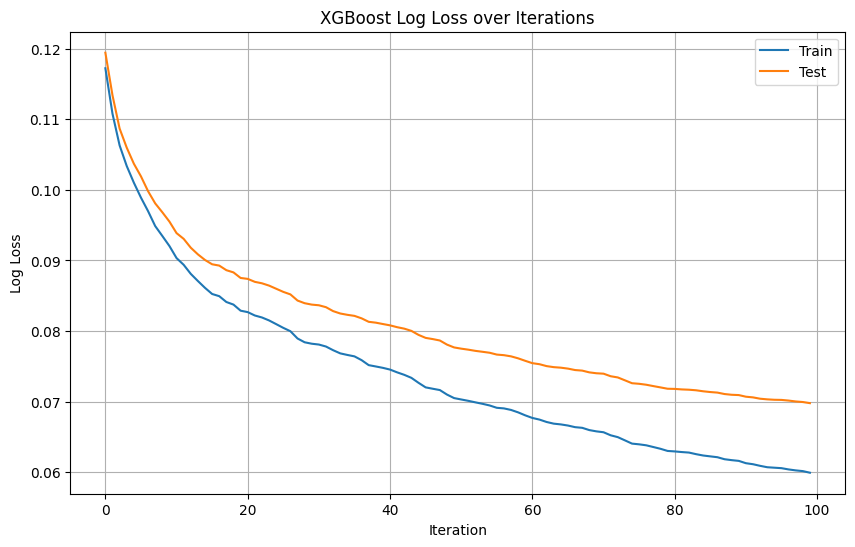

In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

model = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',  # obligatoire pour evals_result()
    random_state=42
)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Pour afficher l’évolution du logloss
results = model.evals_result()

# Courbe du logloss
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['logloss'], label='Train')
plt.plot(results['validation_1']['logloss'], label='Test')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss over Iterations')
plt.legend()
plt.grid(True)
plt.show()


#### Courbe ROC

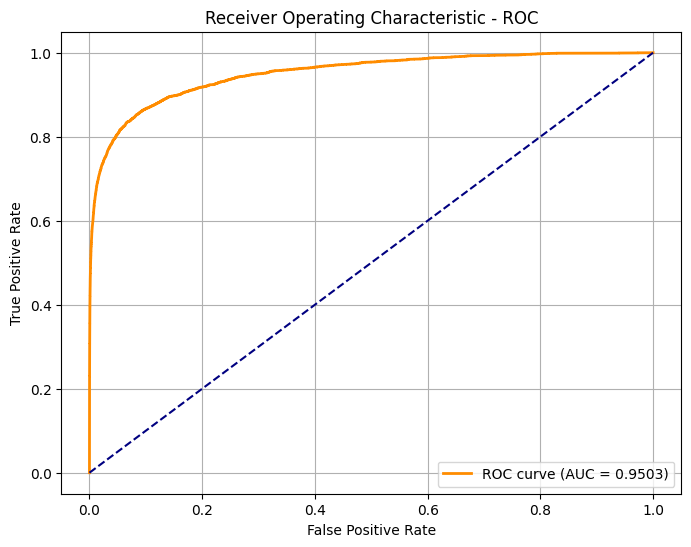

In [26]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()


#### Courbe d’importance des variables

<Figure size 1000x800 with 0 Axes>

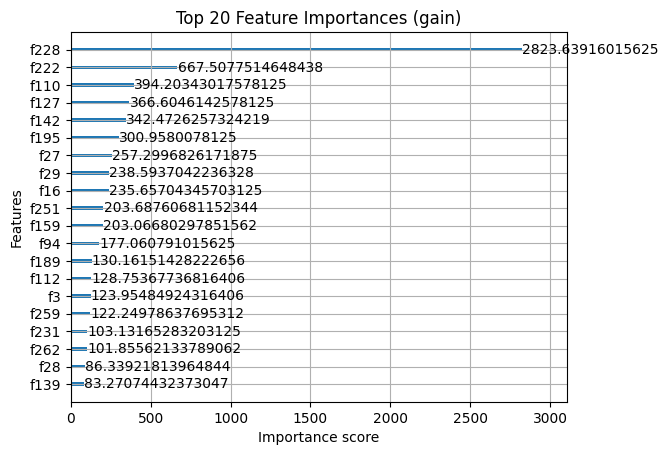

In [27]:
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='gain', max_num_features=20)
plt.title("Top 20 Feature Importances (gain)")
plt.show()


#### Matrice de confusion

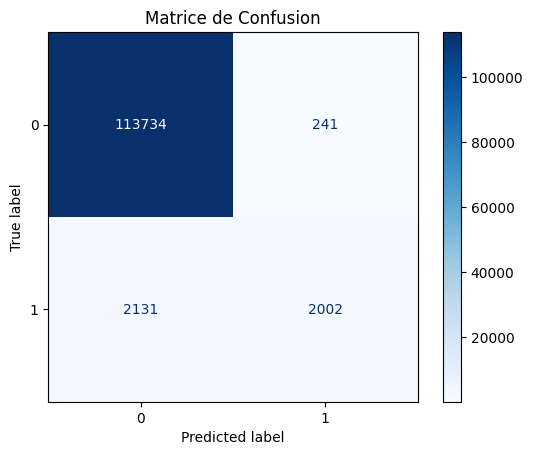

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matrice de Confusion')
plt.grid(False)
plt.show()


#### Sauvegarde avec joblib

In [33]:
import pickle
import os

# Définir le chemin de sauvegarde
save_path = r"E:\Projet_ML_class\xgboost_fraude_model.pkl"

# Créer le dossier s'il n'existe pas (facultatif mais utile)
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Sauvegarder le modèle
with open(save_path, 'wb') as f:
    pickle.dump(model, f)

print(f"✅ Modèle sauvegardé avec succès dans : {save_path}")


✅ Modèle sauvegardé avec succès dans : E:\Projet_ML_class\xgboost_fraude_model.pkl


### SHAP Bar Plot (Importance globale des features)

Mémoire disponible : 2.19 GB
Type des valeurs SHAP : <class 'numpy.ndarray'>
Forme des valeurs SHAP : (50, 265)
Forme des valeurs SHAP sélectionnées : (50, 265)
Forme de X_sample : (50, 265)


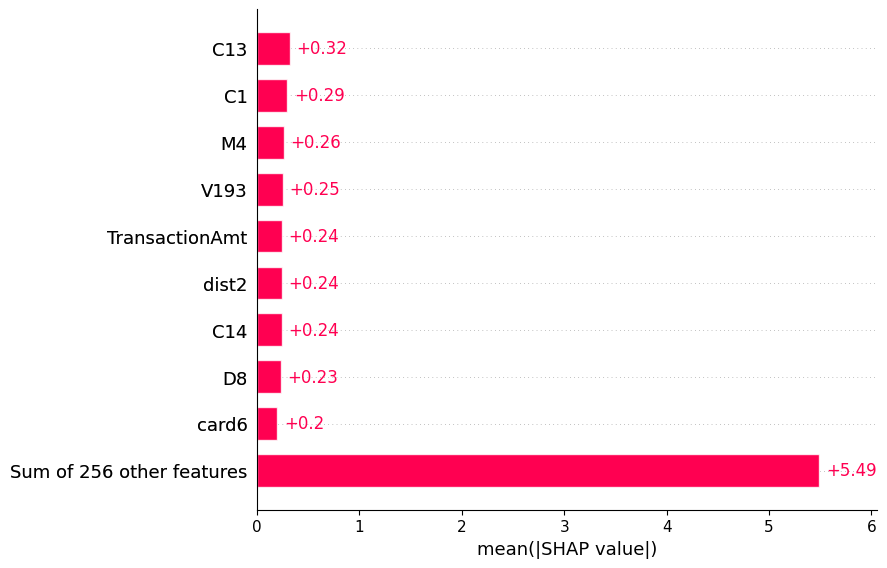

In [13]:
import shap
import numpy as np
import pandas as pd
import psutil  # Pour vérifier la mémoire disponible

# Supposons que X soit votre jeu de données et y les étiquettes correspondantes
# X est votre DataFrame de caractéristiques
# y est votre série d'étiquettes

# Vérifiez la mémoire disponible
available_memory = psutil.virtual_memory().available
print(f"Mémoire disponible : {available_memory / (1024 ** 3):.2f} GB")

# Déterminer la taille de l'échantillon en fonction de la mémoire disponible
# Par exemple, si vous avez moins de 2 GB de mémoire disponible, réduisez encore plus la taille de l'échantillon
if available_memory < 2 * (1024 ** 3):  # 2 GB
    sample_size = 10  # Très petit échantillon
else:
    sample_size = 50  # Petit échantillon

# Échantillonner aléatoirement à partir de l'ensemble du jeu de données
X_sample = X.sample(n=sample_size, random_state=42)

# Calculer les valeurs SHAP pour l'échantillon
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Vérifiez la structure des valeurs SHAP
print("Type des valeurs SHAP :", type(shap_values))
print("Forme des valeurs SHAP :", [sv.shape for sv in shap_values] if isinstance(shap_values, list) else shap_values.shape)

# Si le modèle est un classifieur multi-classes, shap_values sera une liste de tableaux
# Sélectionnez les valeurs SHAP pour la classe qui vous intéresse
if isinstance(shap_values, list):
    shap_values_class = shap_values[1]  # Changez l'indice si nécessaire pour la classe qui vous intéresse
else:
    shap_values_class = shap_values

# Vérifiez si les valeurs SHAP incluent une colonne de biais
if shap_values_class.ndim == 3:
    shap_values_class = shap_values_class[:, :, 0]  # Sélectionnez la première classe

print("Forme des valeurs SHAP sélectionnées :", shap_values_class.shape)
print("Forme de X_sample :", X_sample.shape)

# Assurez-vous que le nombre de caractéristiques correspond
assert shap_values_class.shape[1] == X_sample.shape[1], "Incompatibilité dans le nombre de caractéristiques"

# Calculer la valeur absolue moyenne des valeurs SHAP pour chaque caractéristique
shap_abs_mean = np.abs(shap_values_class).mean(axis=0)

# Créer un DataFrame pour les valeurs SHAP moyennes
shap_df = pd.DataFrame({
    'feature': X_sample.columns,
    'shap_abs_mean': shap_abs_mean
})

# Trier les caractéristiques par importance
shap_df = shap_df.sort_values(by='shap_abs_mean', ascending=False)

# Créer un objet Explanation à partir des valeurs SHAP
shap_explanation = shap.Explanation(values=shap_values_class, base_values=explainer.expected_value, data=X_sample.values, feature_names=X_sample.columns)

# SHAP Bar Plot - Importance globale des caractéristiques
shap.plots.bar(shap_explanation)


##  5. SHAP Decision Plot (chemin de décision pour une instance)

Mémoire disponible : 1.65 GB
Type des valeurs SHAP : <class 'numpy.ndarray'>
Forme des valeurs SHAP : (10, 265)
Forme des valeurs SHAP sélectionnées : (10, 265)
Forme de X_sample : (10, 265)


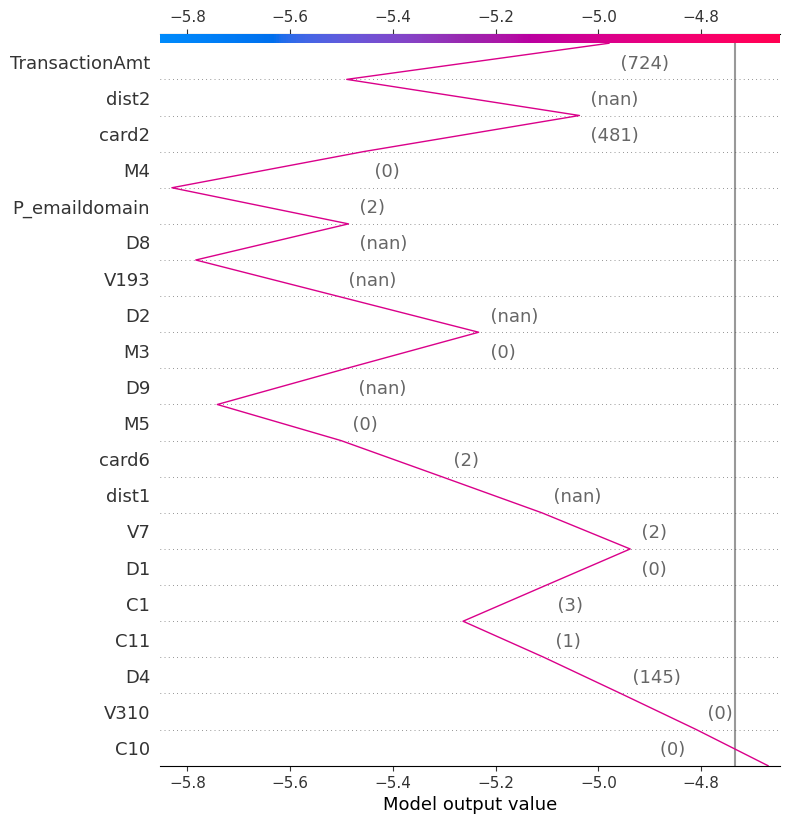

In [15]:
import shap
import numpy as np
import pandas as pd
import psutil  # Pour vérifier la mémoire disponible

# Supposons que X soit votre jeu de données et y les étiquettes correspondantes
# X est votre DataFrame de caractéristiques
# y est votre série d'étiquettes

# Vérifiez la mémoire disponible
available_memory = psutil.virtual_memory().available
print(f"Mémoire disponible : {available_memory / (1024 ** 3):.2f} GB")

# Déterminer la taille de l'échantillon en fonction de la mémoire disponible
# Par exemple, si vous avez moins de 2 GB de mémoire disponible, réduisez encore plus la taille de l'échantillon
if available_memory < 2 * (1024 ** 3):  # 2 GB
    sample_size = 10  # Très petit échantillon
else:
    sample_size = 50  # Petit échantillon

# Échantillonner aléatoirement à partir de l'ensemble du jeu de données
X_sample = X.sample(n=sample_size, random_state=42)

# Calculer les valeurs SHAP pour l'échantillon
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Vérifiez la structure des valeurs SHAP
print("Type des valeurs SHAP :", type(shap_values))
print("Forme des valeurs SHAP :", [sv.shape for sv in shap_values] if isinstance(shap_values, list) else shap_values.shape)

# Si le modèle est un classifieur multi-classes, shap_values sera une liste de tableaux
# Sélectionnez les valeurs SHAP pour la classe qui vous intéresse
if isinstance(shap_values, list):
    shap_values_class = shap_values[1]  # Changez l'indice si nécessaire pour la classe qui vous intéresse
else:
    shap_values_class = shap_values

# Vérifiez si les valeurs SHAP incluent une colonne de biais
if shap_values_class.ndim == 3:
    shap_values_class = shap_values_class[:, :, 0]  # Sélectionnez la première classe

print("Forme des valeurs SHAP sélectionnées :", shap_values_class.shape)
print("Forme de X_sample :", X_sample.shape)

# Assurez-vous que le nombre de caractéristiques correspond
assert shap_values_class.shape[1] == X_sample.shape[1], "Incompatibilité dans le nombre de caractéristiques"

# Calculer la valeur absolue moyenne des valeurs SHAP pour chaque caractéristique
shap_abs_mean = np.abs(shap_values_class).mean(axis=0)

# Créer un DataFrame pour les valeurs SHAP moyennes
shap_df = pd.DataFrame({
    'feature': X_sample.columns,
    'shap_abs_mean': shap_abs_mean
})

# Trier les caractéristiques par importance
shap_df = shap_df.sort_values(by='shap_abs_mean', ascending=False)

# Créer un objet Explanation à partir des valeurs SHAP
shap_explanation = shap.Explanation(values=shap_values_class, base_values=explainer.expected_value, data=X_sample.values, feature_names=X_sample.columns)

# Pour un individu i (exemple : i=0)
i = 0

# Convertir X_sample.columns en liste
feature_names = list(X_sample.columns)

# Decision plot pour un individu i (exemple : i=0)
shap.decision_plot(explainer.expected_value, shap_values_class[i], X_sample.iloc[i], feature_names=feature_names)


## Recupération du modéle Catboost

In [30]:
# pipeline.py

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import joblib

# Fonction de nettoyage

def clean_dataframe(df, missing_thresh=0.9):
    missing = df.isnull().mean()
    to_drop = missing[missing > missing_thresh].index
    df = df.drop(columns=to_drop, errors='ignore')
    df = df.fillna(-999)
    return df

# Encodage des colonnes catégorielles
def encode_categoricals(df):
    for col in df.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

# Pipeline d'entraînement complet
def run_catboost_pipeline(train_df):
    df = clean_dataframe(train_df)
    df = encode_categoricals(df)

    X = df.drop(columns=["isFraud"])
    y = df["isFraud"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    model = CatBoostClassifier(verbose=0, random_state=42, class_weights=[1, 10])
    model.fit(X_train, y_train)

    # Sauvegarder le modèle
    joblib.dump(model, "catboost_model.pkl")

    return model, X_test, y_test


### Tester le modéle

In [2]:
pip install pipeline


Note: you may need to restart the kernel to use updated packages.


In [34]:
import os
print("Répertoire courant :", os.getcwd())


Répertoire courant : C:\Users\DELL\Untitled Folder 3


Erreur : Le fichier C:\Users\DELL\Untitled Folder 3\catboost_training.jsong n'existe pas.

Conseils pour résoudre le problème :
1. Vérifiez que le fichier modèle existe à l'emplacement spécifié
2. Vérifiez que le nom du fichier est correct (extension incluse)
3. Assurez-vous que le pipeline d'entraînement a bien généré le fichier

Contenu du répertoire courant :
['.ipynb_checkpoints', 'Analyse_des_vars_PAC .ipynb', 'catboost_info', 'clustering (1).ipynb', 'clustering.ipynb', 'clustering_new.ipynb', 'Projet_modeles.ipynb', 'Rapport_PEPAM_PE2_Complet.docx', 'Untitled Folder', 'Untitled.ipynb', 'Untitled1.ipynb', 'Untitled2.ipynb']


In [32]:
# test_model.py
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def load_and_preprocess_test_data(test_df):
    """Charge et prétraite les données de test"""
    df = clean_dataframe(test_df)
    df = encode_categoricals(df)
    return df

def evaluate_model(model, X_test, y_test):
    """Évalue les performances du modèle"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

    return y_pred, y_pred_proba

if __name__ == "__main__":
    try:
        # Charger le modèle avec le bon nom de fichier
        model = joblib.load("catboost_training.jsong")

        # Charger les données de test
        test_df = pd.DataFrame({
            'feature1': [1, 2, 3, 4, 5],
            'feature2': ['A', 'B', 'A', 'C', 'B'],
            'isFraud': [0, 1, 0, 1, 0]
        })

        processed_test_df = load_and_preprocess_test_data(test_df)
        X_test = processed_test_df.drop(columns=["isFraud"])
        y_test = processed_test_df["isFraud"]

        evaluate_model(model, X_test, y_test)

    except FileNotFoundError:
        print("Erreur : Le fichier catboost_training.jsong n'a pas été trouvé.")
        print("Veuillez vous assurer que :")
        print("1. Le pipeline d'entraînement a été exécuté avec succès")
        print("2. Le fichier modèle est dans le même répertoire que ce script")
    except Exception as e:
        print(f"Une erreur est survenue : {str(e)}")


Erreur : Le fichier catboost_training.jsong n'a pas été trouvé.
Veuillez vous assurer que :
1. Le pipeline d'entraînement a été exécuté avec succès
2. Le fichier modèle est dans le même répertoire que ce script
